In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from PIL import Image
import random
import warnings
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Accuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, MobileNetV2, DenseNet169
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Checking GPU availability

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Loading train and test dataframes

train_df = pd.read_csv('./../data/cleaned/train.csv')
test_df = pd.read_csv('./../data/cleaned/test.csv')

In [4]:
train_dir = './../data/cleaned/ferplusbalanced/train/'
test_dir = './../data/cleaned/ferplusbalanced/test/'

input_size = (48, 48)
labels = ['anger', 'contempt','disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=0.3,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(48, 48),
                                                    class_mode='categorical',
                                                    subset='training',
                                                    classes=labels,
                                                    batch_size=32)

val_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                target_size=(48, 48),
                                                class_mode='categorical',
                                                subset='validation',
                                                classes=labels,
                                                batch_size=32)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=(48, 48),
                                                  class_mode='categorical',
                                                  classes=labels,
                                                  batch_size=32)

Found 18603 images belonging to 8 classes.
Found 4648 images belonging to 8 classes.
Found 5772 images belonging to 8 classes.


In [5]:
model = Sequential()

# Conv layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(8, activation='softmax'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [6]:
# Fitting model

model_path = './../models/best_custom_model.h5'

callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1),
             ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy')]

history = model.fit(train_generator, validation_data=val_generator, epochs=25, batch_size=64, verbose=2, callbacks=callbacks)

Epoch 1/25
582/582 - 23s - loss: 1.9082 - accuracy: 0.1975 - val_loss: 1.7535 - val_accuracy: 0.3115 - lr: 0.0010 - 23s/epoch - 39ms/step
Epoch 2/25
582/582 - 19s - loss: 1.6204 - accuracy: 0.3633 - val_loss: 1.4143 - val_accuracy: 0.4432 - lr: 0.0010 - 19s/epoch - 33ms/step
Epoch 3/25
582/582 - 19s - loss: 1.4033 - accuracy: 0.4566 - val_loss: 1.2420 - val_accuracy: 0.5198 - lr: 0.0010 - 19s/epoch - 33ms/step
Epoch 4/25
582/582 - 19s - loss: 1.2473 - accuracy: 0.5264 - val_loss: 1.0486 - val_accuracy: 0.5912 - lr: 0.0010 - 19s/epoch - 33ms/step
Epoch 5/25
582/582 - 19s - loss: 1.1444 - accuracy: 0.5693 - val_loss: 1.0001 - val_accuracy: 0.6233 - lr: 0.0010 - 19s/epoch - 33ms/step
Epoch 6/25
582/582 - 19s - loss: 1.0884 - accuracy: 0.5890 - val_loss: 0.9870 - val_accuracy: 0.6364 - lr: 0.0010 - 19s/epoch - 33ms/step
Epoch 7/25
582/582 - 19s - loss: 1.0343 - accuracy: 0.6127 - val_loss: 0.9655 - val_accuracy: 0.6373 - lr: 0.0010 - 19s/epoch - 33ms/step
Epoch 8/25
582/582 - 19s - loss: 0

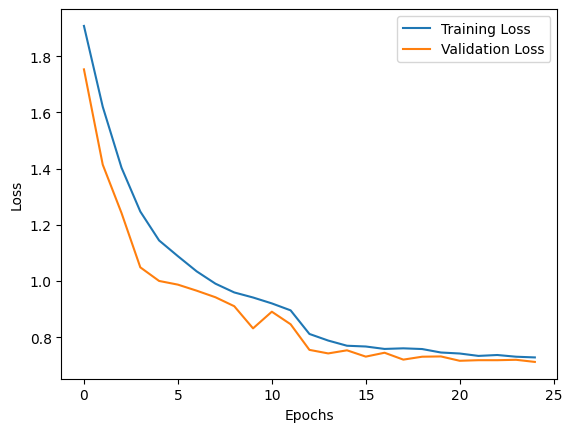

In [7]:
# Plotting train and val losses

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Model evaluation on val set

val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

146/146 [==============================] - 4s 28ms/step - loss: 0.7191 - accuracy: 0.7315
Validation Loss: 0.7191050052642822, Validation Accuracy: 0.7314974069595337


In [9]:
# Making predictions on test set

y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

181/181 [==============================] - 2s 10ms/step


In [10]:
y_true

array([0, 0, 0, ..., 7, 7, 7])

Classification report:
              precision    recall  f1-score   support

           0       0.17      0.16      0.17       871
           2       0.11      0.13      0.12       747
           3       0.14      0.15      0.14       799
           4       0.14      0.14      0.14       837
           5       0.15      0.13      0.14       952
           6       0.12      0.14      0.13       699
           7       0.16      0.15      0.15       867

    accuracy                           0.14      5772
   macro avg       0.14      0.14      0.14      5772
weighted avg       0.14      0.14      0.14      5772

Cohen-Kappa score: -0.001122540241050407


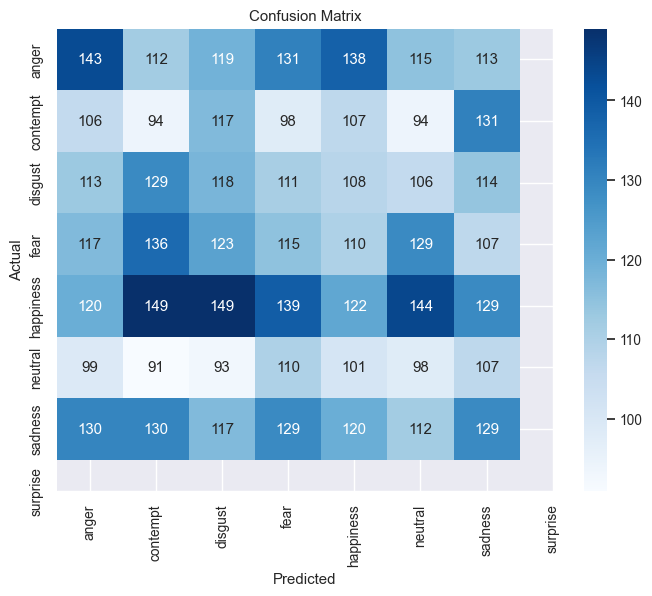

In [11]:
# Performance metrics on test set

cr = classification_report(y_pred_labels, y_true)
print(f'Classification report:\n{cr}')

chs = cohen_kappa_score(y_pred_labels, y_true)
print(f'Cohen-Kappa score: {chs}')

cm = confusion_matrix(y_pred_labels, y_true)

plt.figure(figsize=(8, 6))
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()